In [1]:
import netCDF4
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
ch4 = xr.open_dataset('200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc', engine='netcdf4')
ch4

<xarray.Dataset>
Dimensions:                  (time: 210, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2003-01-16T12:00:00 ... 20...
  * lat                      (lat) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                      (lon) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] ...
    lat_bnds                 (lat, bnds) float64 ...
    lon_bnds                 (lon, bnds) float64 ...
    pre                      (pressure) float64 ...
    pre_bnds                 (pressure, bnds) float64 ...
    land_fraction            (lat, lon) float64 ...
    xch4                     (time, lat, lon) float32 ...
    xch4_nobs                (time, lat, lon) float64 ...
    xch4_stderr              (time, lat, lon) float32 ...
    xch4_stddev              (time, lat, lon) float32 ...
    column_averaging_kernel  (time, pressure, lat, lon) float32 ...
    vmr_profile_ch4_apriori  (time, pressure, lat, lon) float32 ...
Attributes: (12/28)
    activity_id:            obs4MIPs
    comment:                Since long time, climate modellers use ensemble a...
    contact:                Maximilian Reuter (maximilian.reuter@iup.physik.u...
    Conventions:            CF-1.7 ODS-2.1
    creation_date:          2021-02-05T09:48:47Z
    data_specs_version:     2.1.0
    ...                     ...
    source_version_number:  v4.3
    title:                  C3S XCH4 v4.3
    tracking_id:            892d184a-7b35-4bba-836a-94b9cfeb360e
    variable_id:            xch4
    variant_info:           Best Estimate
    variant_label:          BE

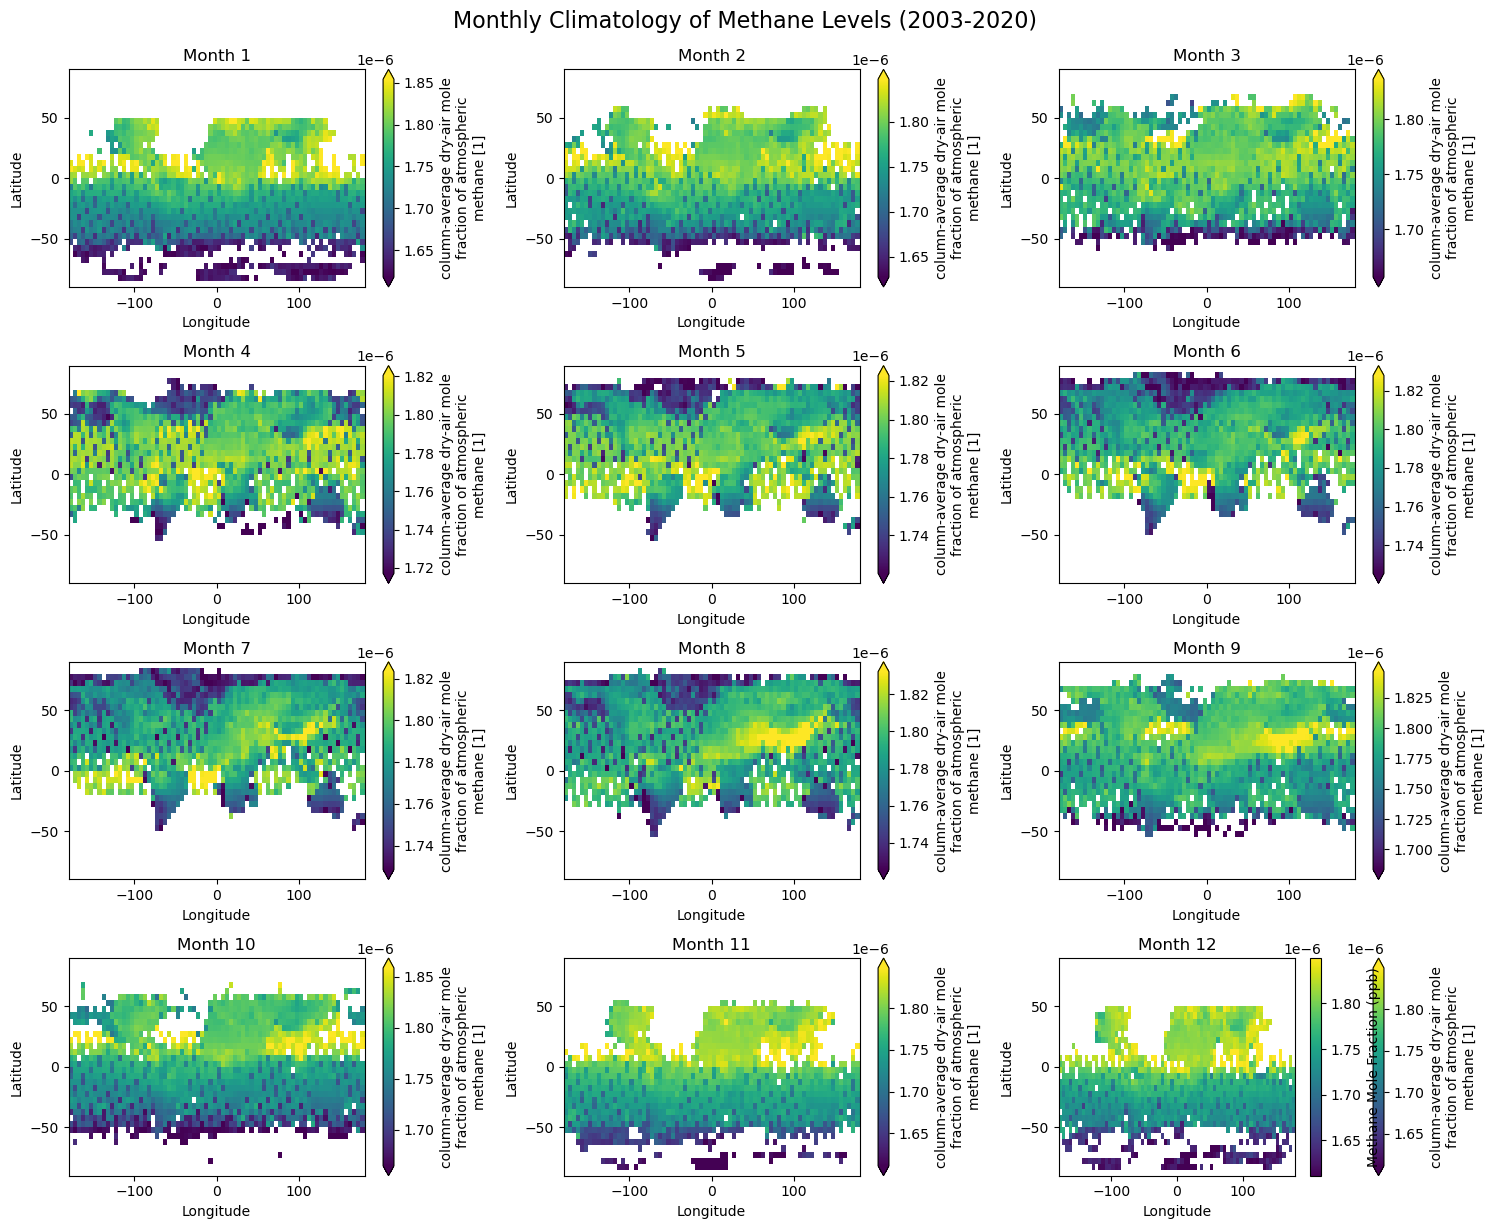

In [5]:
# 1.1
# 提取甲烷浓度数据
xch4 = ch4['xch4']

# 按月份计算气候学平均值
xch4_clim = xch4.groupby('time.month').mean(dim='time')

# 绘制图表
plt.figure(figsize=(15, 12))

# 为每个月创建一个子图
for month in range(1, 13):
    # 4行3列
    plt.subplot(4, 3, month)
    # 使用 robust=True 来动态调整颜色映射
    img = xch4_clim.sel(month=month).plot(cmap='viridis', robust=True)
    # 添加颜色条，仅在最后一个子图中添加
    if month == 12:
        plt.colorbar(img, label='Methane Mole Fraction (ppb)')
    plt.title(f'Month {month}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
plt.tight_layout()
plt.suptitle('Monthly Climatology of Methane Levels (2003-2020)', fontsize=16, y=1.02)
plt.show()

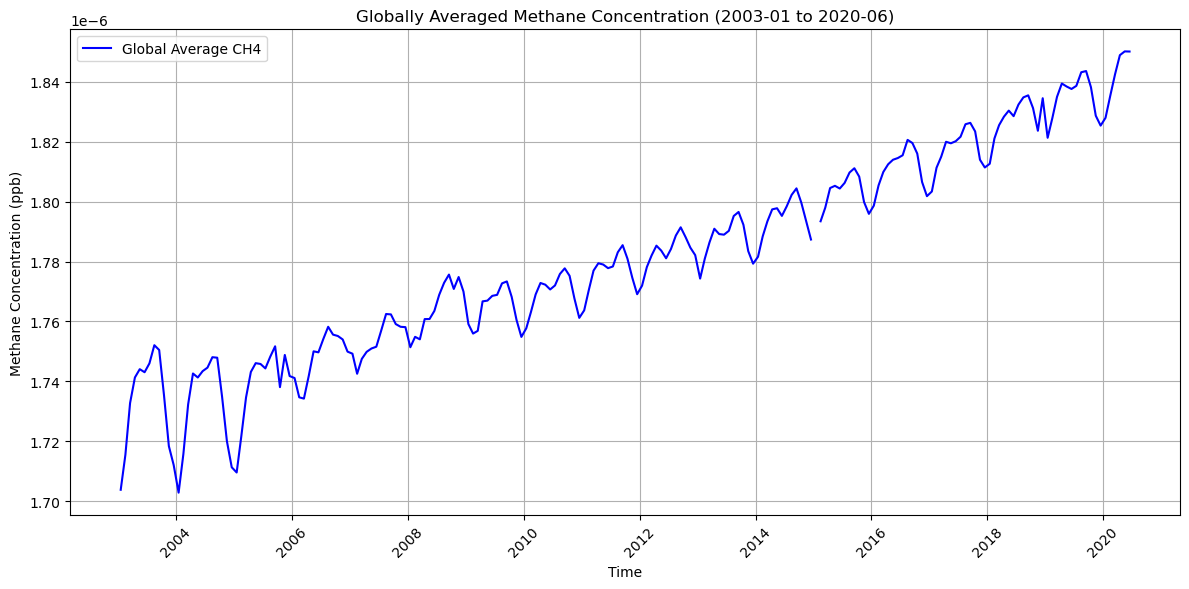

In [7]:
# 1.2
# 计算全球平均甲烷浓度
global_mean_methane = xch4.mean(dim=['lat', 'lon'])

# 绘制图表
plt.figure(figsize=(12, 6))
plt.plot(global_mean_methane['time'], global_mean_methane, label='Global Average CH4', color='blue')
plt.title('Globally Averaged Methane Concentration (2003-01 to 2020-06)')
plt.xlabel('Time')
plt.ylabel('Methane Concentration (ppb)')
# X轴旋转45°
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# 甲烷浓度逐年增加，且呈现季节性变化，夏季较高，冬季较低，在2006年时出现异常值。

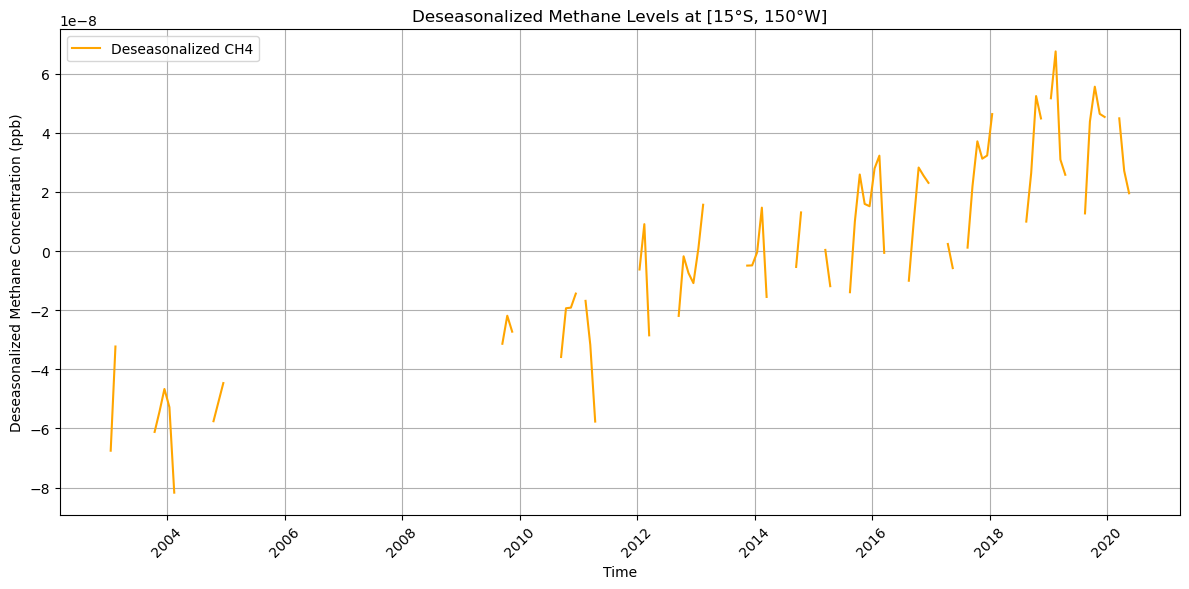

In [9]:
# 1.3
# 选择 [15°S, 150°W]地点的数据
point_data = xch4.sel(lat=-15, lon=150, method='nearest')

# 计算季节性平均值
seasonal_mean = point_data.groupby('time.month').mean(dim='time')

# 计算去季节化数据
deseasonalized_data = point_data - seasonal_mean[point_data['time.month'] - 1]

# 绘制去季节化时间序列
plt.figure(figsize=(12, 6))
plt.plot(deseasonalized_data['time'], deseasonalized_data, label='Deseasonalized CH4', color='orange')
plt.title('Deseasonalized Methane Levels at [15°S, 150°W]')
plt.xlabel('Time')
plt.ylabel('Deseasonalized Methane Concentration (ppb)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# 2
SST = xr.open_dataset('NOAA_NCDC_ERSST_v3b_SST.nc', engine='netcdf4')
SST

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [13]:
#2.1
# 这题我借鉴了我的师姐龙师倩
nino34_sst = SST.sst.sel(lon=slice(120,170),lat=slice(-5,5)).groupby('time.month')
sst_dif = nino34_sst-nino34_sst.mean(dim='time')

# 对异常值进行三个月重采样
anom_resample = sst_dif.resample(time="3M").mean(dim="time")
anom_resample

D:\ANACONDA\Lib\site-packages\xarray\core\groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


<xarray.DataArray 'sst' (time: 229, lat: 5, lon: 26)>
array([[[-0.4533596 , -0.43008804, -0.3652172 , ..., -0.5904255 ,
         -0.51613617, -0.5157356 ],
        [-0.14541245, -0.14106178, -0.20046997, ..., -0.60107803,
         -0.5806999 , -0.5200424 ],
        [ 0.03437614, -0.01860619, -0.1291542 , ..., -0.61279106,
         -0.5868416 , -0.55138206],
        [-0.03416824, -0.07881355, -0.139431  , ..., -0.5768242 ,
         -0.56368065, -0.5451031 ],
        [-0.11306   , -0.14630127, -0.18651962, ..., -0.47527504,
         -0.48386002, -0.49680328]],

       [[-0.29540953, -0.25229773, -0.21316402, ..., -0.6501789 ,
         -0.5796814 , -0.58689374],
        [-0.18128014, -0.12417793, -0.13654137, ..., -0.6904233 ,
         -0.68461037, -0.64244586],
        [-0.09715843, -0.08390108, -0.10546494, ..., -0.7069289 ,
         -0.6881733 , -0.6722056 ],
        [-0.18694179, -0.16128285, -0.128987  , ..., -0.64433545,
         -0.62889546, -0.6225446 ],
        [-0.27703476, -0.2525959 , -0.20511119, ..., -0.517519  ,
...
          0.51037025,  0.44631258],
        [ 0.31214967,  0.4855779 ,  0.7164224 , ...,  0.4436461 ,
          0.3200194 ,  0.2053426 ],
        [ 0.39565277,  0.5145791 ,  0.7320716 , ...,  0.39797845,
          0.23362541,  0.08429018],
        [ 0.44386673,  0.44989267,  0.5983505 , ...,  0.5368557 ,
          0.3789749 ,  0.21928024],
        [ 0.42669234,  0.40143776,  0.4725081 , ...,  0.714798  ,
          0.5879669 ,  0.46769652]],

       [[ 0.32543087,  0.3451271 ,  0.4029932 , ...,  0.51263714,
          0.4383192 ,  0.36778736],
        [ 0.42484474,  0.5078449 ,  0.57851505, ...,  0.34471035,
          0.22703075,  0.10994244],
        [ 0.5032301 ,  0.5828867 ,  0.66394806, ...,  0.27353382,
          0.13096333, -0.00620747],
        [ 0.46020794,  0.49208736,  0.58321095, ...,  0.37838078,
          0.25306892,  0.11438084],
        [ 0.3544016 ,  0.36249638,  0.44186687, ...,  0.5236778 ,
          0.4169016 ,  0.31012917]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -4.0 -2.0 0.0 2.0 4.0
  * lon      (lon) float32 120.0 122.0 124.0 126.0 ... 164.0 166.0 168.0 170.0
  * time     (time) datetime64[ns] 1960-01-31 1960-04-30 ... 2017-01-31

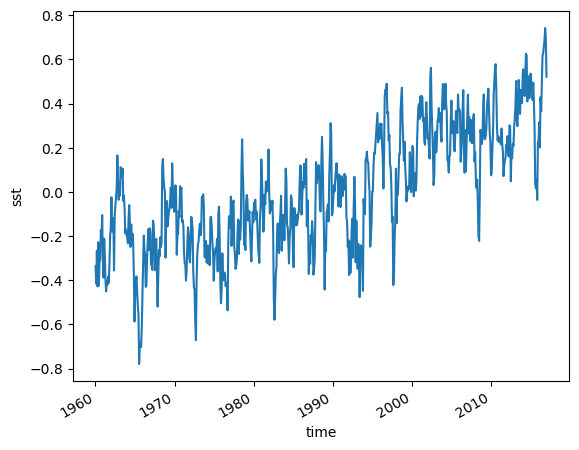

In [15]:
# 2.2
# 对去季节性变化进行可视化
sst_dif.mean(dim=['lat','lon']).plot()

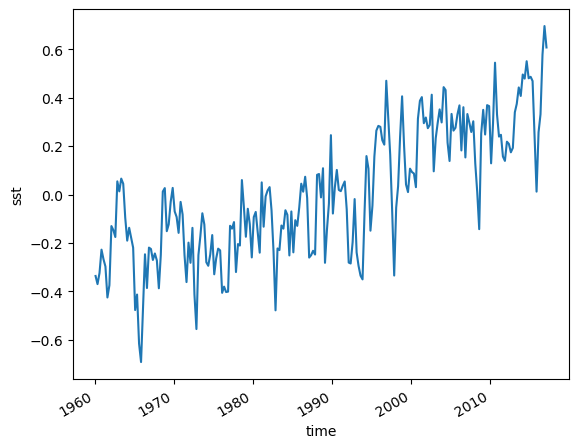

In [17]:
anom_resample.mean(dim=['lat','lon']).plot()

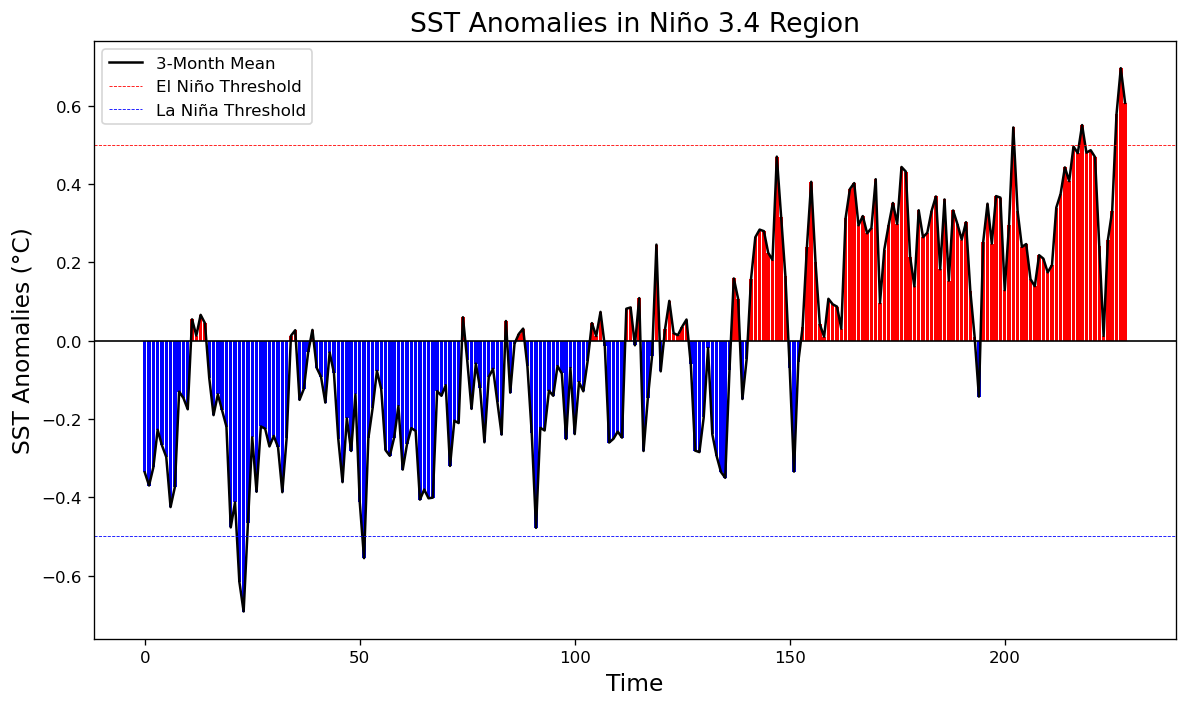

In [19]:
# 对三个月重采样后的异常值进行空间平均
anom_resample_m = anom_resample.mean(dim=['lat', 'lon'])

# 创建数据库，选择 SST >= 0的部分，命名为 anom >= 0
df = pd.DataFrame(anom_resample_m.where(anom_resample_m >= 0), columns=['anom>=0'])
# 将小于0的部分添加在新列 anom <= 0
df['anom<0'] = pd.DataFrame(anom_resample_m.where(anom_resample_m < 0))
# 添加日期列
df['date'] = pd.DataFrame(anom_resample_m.time)
# 将日期列作为索引，便于绘图时将日期列作为x轴
df.set_index('date', inplace=True)

plt.figure(figsize=(10, 6), dpi=120)

# 绘制正异常值柱状图
plt.bar(np.arange(len(df['anom>=0'])), df['anom>=0'], color="red")

# 绘制负异常值柱状图
plt.bar(np.arange(len(df['anom<0'])), df['anom<0'], color="blue")

# 绘制三个月平均异常值的线图
plt.plot(anom_resample_m, 'k-', label='3-Month Mean')

# 添加阈值线
plt.axhline(y=0.5, color="red", linestyle='--', linewidth=0.5, label='El Niño Threshold')
plt.axhline(y=-0.5, color="blue", linestyle='--', linewidth=0.5, label='La Niña Threshold')
plt.axhline(y=0, color="black", linestyle='-', linewidth=1)

# 设置图例
plt.legend(loc='upper left')

# 添加标签和标题
plt.ylabel('SST Anomalies (°C)', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('SST Anomalies in Niño 3.4 Region', fontsize=16)

# 显示图形
plt.tight_layout()
plt.show()

In [27]:
#这里我咨询了欧阳文剑同学关于如何导入文件的问题
import xarray as xr
import glob
# 定义文件路径模式
file_pattern = 'D:\\ESE5023\\output_file\\*.nc4'

# 获取所有匹配的文件路径
files = glob.glob(file_pattern)

# 读取并合并多个文件
CO2 = xr.open_mfdataset(files, combine='by_coords')

# 查看合并后的数据集
CO2

<xarray.Dataset>
Dimensions:   (lat: 361, lon: 576, time: 86)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 2015-01-16T12:00:00 ... 2022-02-15
Data variables:
    XCO2      (time, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    XCO2PREC  (time, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
Attributes: (12/25)
    RangeBeginningDate:             2017-08-01
    RangeBeginningTime:             00:00:00.000000
    RangeEndingDate:                2017-08-01
    RangeEndingTime:                23:59:99.999999
    SpatialCoverage:                global
    SouthBoundingCoordinate:        -90.0
    ...                             ...
    ProductionDateTime:             2022-03-15T12:04:33Z
    History:                        Original file generated: Tue Mar 15 12:04...
    ShortName:                      OCO2_GEOS_L3CO2_MONTH_10r
    LongName:                       OCO-2 GEOS Level 3 monthly, 0.5x0.625 ass...
    Title:                          OCO-2 GEOS Level 3 monthly, 0.5x0.625 ass...
    IdentifierProductDOI:           10.5067/BGFIODET3HZ8

D:\ANACONDA\Lib\site-packages\xarray\core\groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


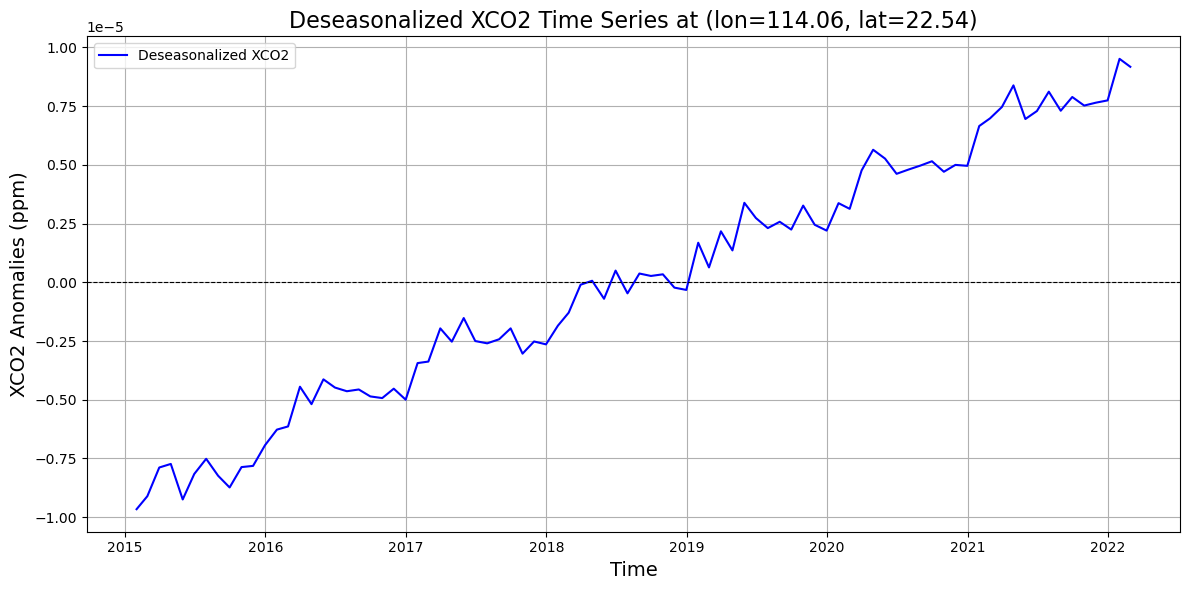

In [33]:
# 3.1 
# 我绘制了深圳市（lon=114.06, lat=22.54）的XCO2的时间序列
# 使用 sel 方法选择深圳市的经纬度
xco2_selected = CO2['XCO2'].sel(lon=114.06, lat=22.54, method='nearest')  # 使用最近邻选择

# 计算每月的平均值（季节性成分）
monthly_mean = xco2_selected.groupby('time.month').mean(dim='time')

# 去季节化：计算异常值
xco2_deseasonalized = xco2_selected - monthly_mean[xco2_selected['time.month'] - 1]

# 获取时间序列
time_series = xco2_deseasonalized.resample(time='M').mean()  # 按月重采样

# 5. 绘制去季节化后的时间序列
plt.figure(figsize=(12, 6))
plt.plot(time_series['time'], time_series, label='Deseasonalized XCO2', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Deseasonalized XCO2 Time Series at (lon=114.06, lat=22.54)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('XCO2 Anomalies (ppm)', fontsize=14)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Mean XCO2')

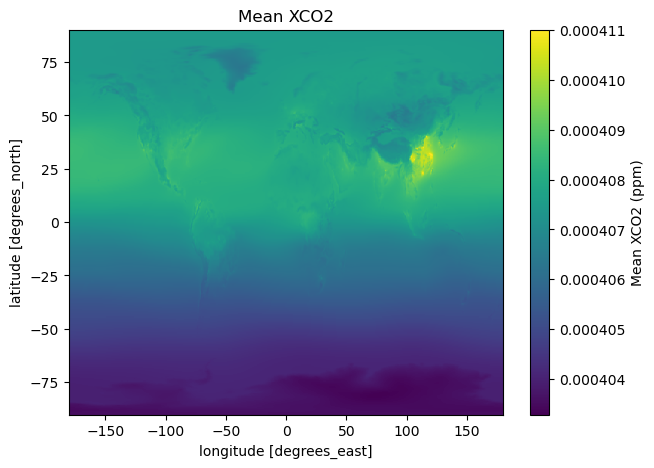

In [55]:
# 3.2.1
# 计算XCO2的平均浓度在不同地点的变化
xco2 = CO2['XCO2']  

# 计算 XCO2的整体平均值
xco2_mean = xco2.mean(dim='time')

plt.figure(figsize=(7, 5))

# 绘制 XCO2 的整体平均值
xco2_mean.plot(cmap='viridis', cbar_kwargs={'label': 'Mean XCO2 (ppm)'})
plt.title('Mean XCO2')

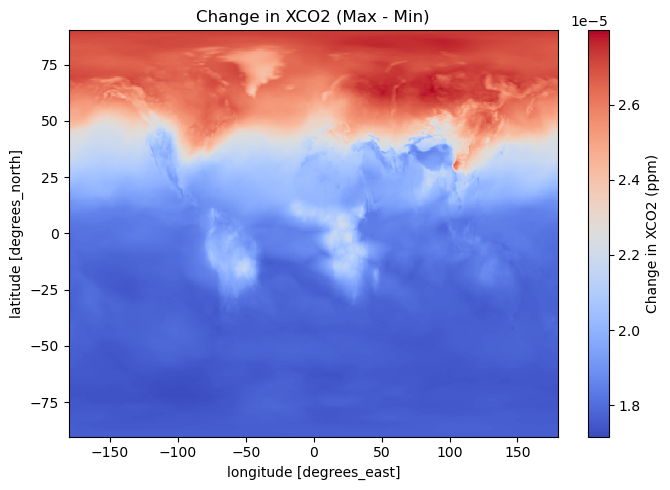

In [61]:
# 3.2.2
# 计算 XCO2 最大值与最小值之间的差异
xco2_change = xco2.max(dim='time') - xco2.min(dim='time')

plt.figure(figsize=(7, 5))
# 绘制 XCO2 的变化（最大值 - 最小值）
xco2_change.plot(cmap='coolwarm', cbar_kwargs={'label': 'Change in XCO2 (ppm)'})
plt.title('Change in XCO2 (Max - Min)')
plt.tight_layout()
plt.show()

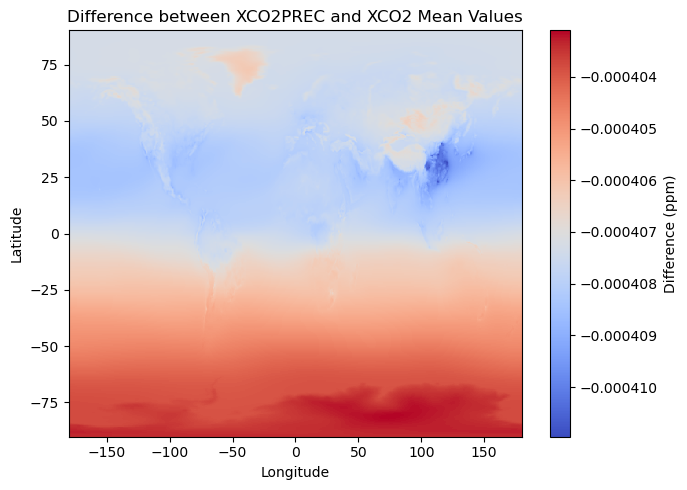

In [65]:
# 3.2.3
# 计算精确的 XCO2值与XCO2值的差异
xco2_prec = CO2['XCO2PREC']

# 计算XCO2PREC的平均值
xco2_prec_mean = xco2_prec.mean(dim='time')

# 计算二者之间的差异
difference = xco2_prec_mean - xco2_mean

# 绘制图形
plt.figure(figsize=(7, 5))
difference.plot(cmap='coolwarm', cbar_kwargs={'label': 'Difference (ppm)'})
plt.title('Difference between XCO2PREC and XCO2 Mean Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

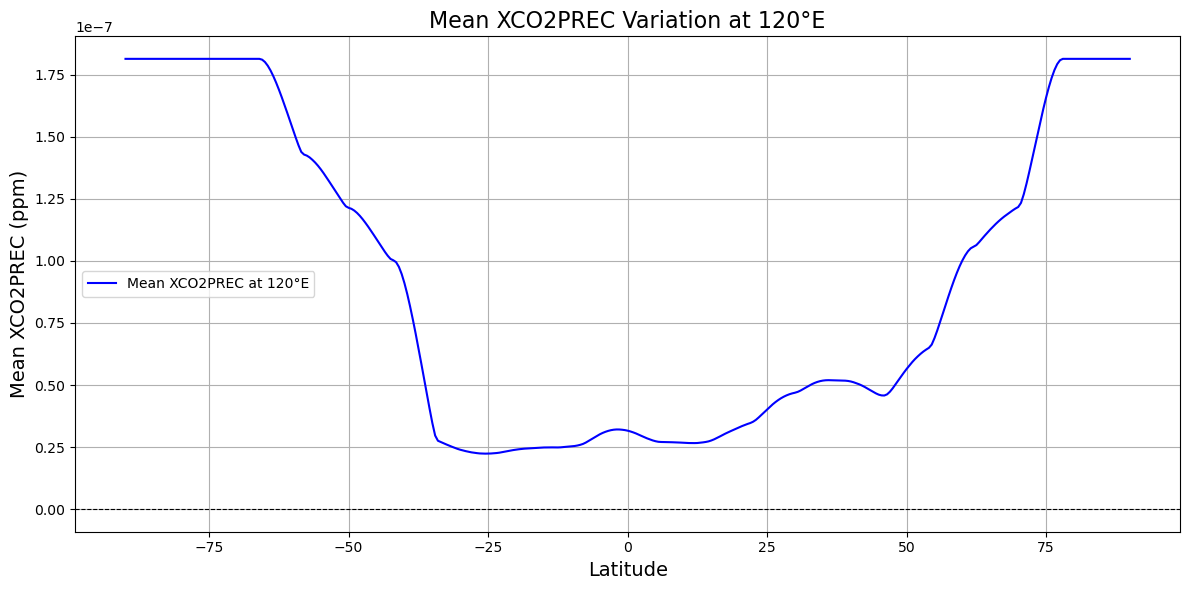

In [71]:
# 3.2.4
# 绘制在 120°E经度线上 XCO2PREC的均值变化
# 选择经度为 120°E的数据
xco2_prec_120E = xco2_prec.sel(lon=120, method='nearest')

# 计算 XCO2PREC的时间平均值
xco2_prec_mean = xco2_prec_120E.mean(dim='time')

# 绘制 XCO2PREC在 120°E的平均值变化
plt.figure(figsize=(12, 6))
xco2_prec_mean.plot(label='Mean XCO2PREC at 120°E', color='blue')
plt.title('Mean XCO2PREC Variation at 120°E', fontsize=16)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Mean XCO2PREC (ppm)', fontsize=14)
# 添加水平线（0线）
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

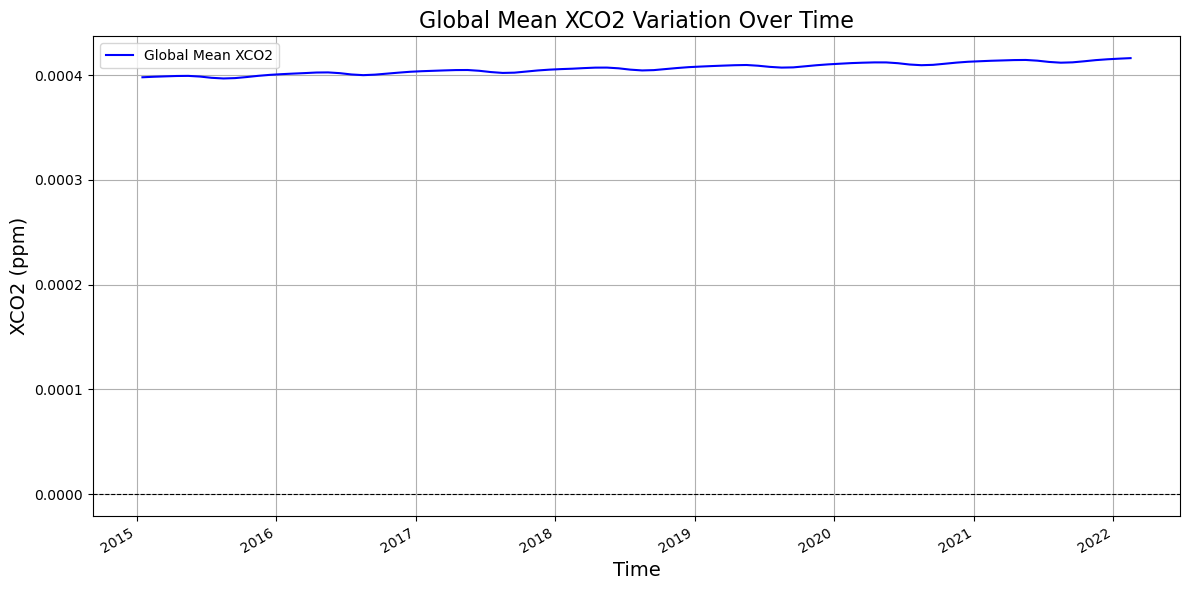

In [77]:
# 3.2.5
# 计算全球的 XCO2均值在时间上的变化
# 计算全球的XCO2的时间均值
xco2_global_mean = xco2.mean(dim=('lat', 'lon'))

#绘制全球 XCO2 均值随时间的变化
plt.figure(figsize=(12, 6))
xco2_global_mean.plot(label='Global Mean XCO2', color='blue')

plt.title('Global Mean XCO2 Variation Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('XCO2 (ppm)', fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()